In [1]:
# Klasyfikacja domen - Piotr Bajuk
# Wykonane zostały model regresji logistycznej oraz las losowy

In [ ]:
import pandas as pd
import seaborn as sns
from ast import literal_eval

In [2]:
# Wczytanie danych z plików csv
df_benign = pd.read_csv('CSV_benign.csv') # bezpieczne
df_malware = pd.read_csv('CSV_malware.csv') # niebezpieczne

D:\programy\python\envs\pajton\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (9,10,12,13,17,18,20,21,24,25,27,28,36) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# Analiza kolumn występujących w zbiorach
df_benign.columns
df_malware.columns

Index(['Country', 'ASN', 'TTL', 'IP', 'Domain', 'oc_8', 'longest_word',
       'Domain_Name', 'dec_32', 'subdomain', 'sld', 'Registrant_Name',
       'hex_32', 'Domain_Age', 'entropy', 'Name_Server_Count', 'Emails',
       'Creation_Date_Time', 'Organization', 'char_distribution', '2gram',
       'State', 'oc_32', 'Country.1', 'Page_Rank', 'hex_8', 'dec_8', '1gram',
       'len', 'typos', 'tld', 'shortened', 'Registrar', 'obfuscate_at_sign',
       'Alexa_Rank', '3gram', 'numeric_percentage', 'puny_coded'],
      dtype='object')

In [4]:
# Wykorzystamy jedynie kolumny wspólne w obu ramkach
set(df_benign.columns) | set(df_malware.columns)

{'1gram',
 '2gram',
 '3gram',
 'ASN',
 'Alexa_Rank',
 'Country',
 'Country.1',
 'Creation_Date_Time',
 'Domain',
 'Domain_Age',
 'Domain_Name',
 'Emails',
 'IP',
 'Name_Server_Count',
 'Organization',
 'Page_Rank',
 'Registrant_Name',
 'Registrar',
 'State',
 'TTL',
 'char_distribution',
 'dec_32',
 'dec_8',
 'entropy',
 'hex_32',
 'hex_8',
 'len',
 'longest_word',
 'numeric_percentage',
 'obfuscate_at_sign',
 'oc_32',
 'oc_8',
 'puny_coded',
 'shortened',
 'sld',
 'subdomain',
 'tld',
 'typos'}

In [5]:
# Kolummy, ktore się różnią
set(df_benign.columns) - set(df_malware.columns)

set()

In [6]:
# Obie ramki danych posiadają te same kolumny. Dodajmy labele
df_benign['label'] = 0
df_malware['label'] = 1

In [7]:
# Zobaczmy braki danych - skupmy się na ramce df_malware, która 
# posiada zdecydowanie mniej danych
df_malware.isna().sum()

Country                946
ASN                    944
TTL                      0
IP                     901
Domain                   0
oc_8                     0
longest_word             0
Domain_Name           1031
dec_32                   0
subdomain                0
sld                      0
Registrant_Name       4926
hex_32                   0
Domain_Age             571
entropy                  0
Name_Server_Count      571
Emails                1622
Creation_Date_Time    1175
Organization          2716
char_distribution        0
2gram                    0
State                 2367
oc_32                    0
Country.1             2109
Page_Rank              571
hex_8                    0
dec_8                    0
1gram                    0
len                      0
typos                    0
tld                      0
shortened               61
Registrar             1306
obfuscate_at_sign        0
Alexa_Rank             571
3gram                    0
numeric_percentage       0
p

In [8]:
# Mamy sporo braków

In [9]:
# Zaczynamy od malware - testowo przejdźmy cały proces oczyszczania przed implementacją pipeline'u
df_malware.isna().sum()

Country                946
ASN                    944
TTL                      0
IP                     901
Domain                   0
oc_8                     0
longest_word             0
Domain_Name           1031
dec_32                   0
subdomain                0
sld                      0
Registrant_Name       4926
hex_32                   0
Domain_Age             571
entropy                  0
Name_Server_Count      571
Emails                1622
Creation_Date_Time    1175
Organization          2716
char_distribution        0
2gram                    0
State                 2367
oc_32                    0
Country.1             2109
Page_Rank              571
hex_8                    0
dec_8                    0
1gram                    0
len                      0
typos                    0
tld                      0
shortened               61
Registrar             1306
obfuscate_at_sign        0
Alexa_Rank             571
3gram                    0
numeric_percentage       0
p

In [10]:
# Brakujący country możemy zamienić na NaD - no a data
df_malware['Country'] = df_malware['Country'].fillna("NaD")

In [11]:
# ASN - usuwamy braki w danych
df_malware = df_malware.dropna(subset=['ASN'])

In [12]:
df_malware.isna().sum()

Country                  0
ASN                      0
TTL                      0
IP                       0
Domain                   0
oc_8                     0
longest_word             0
Domain_Name            843
dec_32                   0
subdomain                0
sld                      0
Registrant_Name       3993
hex_32                   0
Domain_Age             472
entropy                  0
Name_Server_Count      472
Emails                1361
Creation_Date_Time     971
Organization          2303
char_distribution        0
2gram                    0
State                 2018
oc_32                    0
Country.1             1787
Page_Rank              472
hex_8                    0
dec_8                    0
1gram                    0
len                      0
typos                    0
tld                      0
shortened               48
Registrar             1085
obfuscate_at_sign        0
Alexa_Rank             472
3gram                    0
numeric_percentage       0
p

In [13]:
# Domain_name, Registrant_Name - usuwamy kolumny - za dużo unikalnych
# i za duzo braków
df_malware = df_malware.drop(columns=['Domain_Name', 'Registrant_Name'])

In [14]:
# Usuwamy braki z Domain_Age - może to być istotna kolumna
df_malware = df_malware.dropna(subset=['Domain_Age'])


In [15]:
# Usuwamy Emails, Creation_Date_Time, Organization, State, Country.1, 
# shortened, Registrar - nie damy rady imputować
df_malware = df_malware.drop(columns=['Emails', 
                                      'Creation_Date_Time', 
                                      'Organization',
                                      'State',
                                      'Country.1',
                                      'shortened',
                                      'Registrar'])

In [16]:
df_malware.isna().sum()

Country               0
ASN                   0
TTL                   0
IP                    0
Domain                0
oc_8                  0
longest_word          0
dec_32                0
subdomain             0
sld                   0
hex_32                0
Domain_Age            0
entropy               0
Name_Server_Count     0
char_distribution     0
2gram                 0
oc_32                 0
Page_Rank             0
hex_8                 0
dec_8                 0
1gram                 0
len                   0
typos                 0
tld                   0
obfuscate_at_sign     0
Alexa_Rank            0
3gram                 0
numeric_percentage    0
puny_coded            0
label                 0
dtype: int64

In [17]:
# Usuwamy pozostałe kolumny, które zostały uznane za niezdatne
df_malware = df_malware.drop(columns=['char_distribution', 
                                      '1gram', 
                                      '2gram',
                                      'typos'])

In [18]:
# Zajmijmy się kolumna Domain_Age - pozyskajmy liczbe dni
def clear_d_age(row):
    try:
        data = row.split(' ')[0]
        return int(data)
    except:
        return 0

In [19]:
df_malware['Domain_Age'] = df_malware['Domain_Age'].apply(lambda data: clear_d_age(data))

In [20]:
# Kolumna 3gram na string i OHE
df_malware['3gram'] = df_malware.loc[:,'3gram'].apply(lambda x: literal_eval(x))

In [21]:
def clear_3gram(row):
    try:
        data = ','.join(row)
        return data
    except:
        return 'no_data'

In [22]:
df_malware['3gram'] = df_malware['3gram'].apply(lambda data: clear_3gram(data))

In [23]:
# Usuwamy z TTL nieliczbowe dane
df_malware = df_malware[df_malware["TTL"].str.contains("b'") == False] 

In [24]:
# TTL na int
df_malware['TTL'] = df_malware['TTL'].astype(int)

In [25]:
# Domain - usuwamy, bo za duzo unikalnych. Zostawiamy sld
df_malware = df_malware.drop(columns=['Domain', 'longest_word'])


In [26]:
# Moglibysmy utworzyc tez kolumny z 3gram, ale bedzie za duzo. 
# Usuwamy 3gram
df_malware = df_malware.drop(columns=['3gram'])


In [27]:
# Zaczynamy tworzyć kolumny z danych str
one_hot_df = pd.get_dummies(df_malware, columns=['Country', 
                                                 'IP',
                                                 'sld',
                                                 'tld'])


In [28]:
# Gowowy pipeline na podstawie dotychczasowych testów
def pipeline(dataframe):
    dataframe['Country'] = dataframe['Country'].fillna("NaD")
    dataframe = dataframe.dropna(subset=['ASN'])
    dataframe = dataframe.dropna(subset=['Domain_Age'])
    dataframe = dataframe.dropna(subset=['IP'])
    
    dataframe = dataframe.drop(columns=['Domain_Name', 
                                          'Registrant_Name',
                                          'Emails', 
                                          'Creation_Date_Time',
                                          'Organization',
                                          'State',
                                          'Country.1',
                                          'shortened',
                                          'Registrar',
                                          'char_distribution', 
                                          '1gram', 
                                          '2gram',
                                          'typos',
                                          'Domain', 
                                          'longest_word',
                                          '3gram'
                                          ])
    dataframe['Domain_Age'] = dataframe['Domain_Age'].apply(lambda data: clear_d_age(data))
    try:
        dataframe = dataframe[dataframe["TTL"].str.contains("b'") != True] 
    except:
        pass
    dataframe['TTL'] = dataframe['TTL'].astype(int)
    
    one_hot_df = pd.get_dummies(dataframe, columns=['Country', 'IP', 'sld', 'tld'])
    
    # Konwersja kazdej z kolumn na int - jeseli sie nie da - wstawiamy NaN
    for col in one_hot_df.columns:
        one_hot_df[col] = pd.to_numeric(one_hot_df[col], errors='coerce')
        
    one_hot_df.dropna()

    return one_hot_df 

In [29]:
# Mając funkcję pipeline rozpoczynamy od nowa od wczytania danych i przygotowania ich do uczenia maszynowego
# z wykorzystaniem pipeline.

In [30]:
df_benign = pd.read_csv('CSV_benign.csv') # bezpieczne
df_malware = pd.read_csv('CSV_malware.csv') # niebezpieczne

# Z racji dużej dysproporcji w danych skupimy się na fragmencie danych z ramki df_benign o długości równej ramce df_malware.
# Połączymy ją z malware i wykorzystajmy pipeline
df_benign_sample = df_benign.sample(len(df_malware), random_state=123)

In [31]:
# Obie ramki danych posiadają te same kolumny. Dodajmy labele
df_benign_sample['label'] = 0
df_malware['label'] = 1

In [32]:
# Łączymy ramki
df_ML = pd.concat([df_benign_sample, df_malware], axis = 0)

In [33]:
# Wrzucamy do pipeline
df_ML = pipeline(df_ML)

In [34]:
# Na wszelki wypadek usuwamy braki w danych
df_ML = df_ML.dropna()

In [35]:
# Balans klasowy
df_ML['label'].value_counts()

1    3561
0    2679
Name: label, dtype: int64

In [36]:
# Okazuje się, że mamy więcej 0. Dajmy większą liczbę próbek z klasy 0
df_benign_sample = df_benign.sample(len(df_malware)+1000, random_state=123)
df_benign_sample['label'] = 0
# Łączymy ramki
df_ML = pd.concat([df_benign_sample, df_malware], axis = 0)
# Wrzucamy do pipeline
df_ML = pipeline(df_ML)
# Na wszelki wypadek usuwamy braki w danych
df_ML = df_ML.dropna()

In [37]:
# Balans klasowy - podobny, o to nam chodzi
df_ML['label'].value_counts()

1    3561
0    3244
Name: label, dtype: int64

In [38]:
# Uczenie maszynowe
X = df_ML.drop(columns=['label'])
Y = df_ML['label']

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [40]:
# Podział danych na treningowe i testowe (0.8 - 0.2) 
# Dla uzyskania takich samych wyników przy ponownym uruchomieniu ustalamy jakiś random state (tutaj 123)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=123) 

In [41]:
# Skaler - dopasowanie do treningowych, a następnei normalizacja testowych z uzyskanymi wcześniej hiperparametrami.
min_max_scaler = MinMaxScaler()
x_train_norm = min_max_scaler.fit_transform(x_train)
x_test_norm = min_max_scaler.transform(x_test)

In [42]:
# Krzywa ROC
from sklearn import metrics

def ROC(model, X_test, y_test):
    y_pred_proba = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)

    #create ROC curve
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()

In [43]:
# Regresja logistyczna
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
logistic = LogisticRegression()
logistic.fit(x_train_norm, y_train)

LogisticRegression()

In [44]:
from sklearn.metrics import classification_report,confusion_matrix
y_pred_logistic = logistic.predict(x_test_norm)

In [45]:
confusion_matrix(y_test, y_pred_logistic)

array([[481, 175],
       [142, 563]], dtype=int64)

In [46]:
print(classification_report(y_test, y_pred_logistic))

              precision    recall  f1-score   support

           0       0.77      0.73      0.75       656
           1       0.76      0.80      0.78       705

    accuracy                           0.77      1361
   macro avg       0.77      0.77      0.77      1361
weighted avg       0.77      0.77      0.77      1361



In [ ]:
# Dokładność - przedstawia stosunek wszystkich poprawnie sklasyfikowanych przypadków (TP + TN) do całkowitej liczby przypadków. 
# dokładność wynosi 0.77, co oznacza, że 77% przypadków zostało sklasyfikowanych poprawnie.
# Precyzja - stosunek TP do wszystkich sklasyfikowanych przypadków sklasyfikowanych jako pozytywne, dla klasy 0 jest równa 0,77 natomiast dla klasy 0 = 0,76
# Oznacza to, że model poprawnie przewiduje przewiduje 77% przypadków, a dla klasy 1 - 76% przypadków.

# Czułość - stosunek TP do do wszystkich rzeczywistych pozytywnych przypadków Oznacza to, że model wykrywa 73% przypadków klasy 0 i 80% przypadków klasy 1.

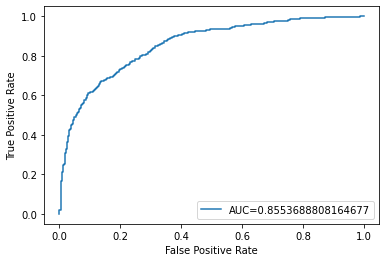

In [47]:
# Krzywa ROC
ROC(logistic, x_test_norm, y_test)

In [ ]:
# W przypadku krzywej ROC należy zwrócić uwagę na obszar znajdujący się pod krzywą, w analizowanym przypadku wynosi od 0,8553..
# Im bardziej krzywa jest "uniesiona" w kierunku lewego górnego rogu wykresu (w stronę czułości równej 1 i specyficzności równej 1),
# tym lepsza jest wydajność modelu.

In [48]:
# Las losowy
from sklearn.ensemble import RandomForestClassifier

In [49]:
RandomForest_model = RandomForestClassifier()
RandomForest_model.fit(x_train_norm, y_train)

y_pred_forest = RandomForest_model.predict(x_test_norm)

In [50]:
confusion_matrix(y_test, y_pred_forest)

array([[522, 134],
       [ 81, 624]], dtype=int64)

In [51]:
print(classification_report(y_test, y_pred_forest))

              precision    recall  f1-score   support

           0       0.87      0.80      0.83       656
           1       0.82      0.89      0.85       705

    accuracy                           0.84      1361
   macro avg       0.84      0.84      0.84      1361
weighted avg       0.84      0.84      0.84      1361



In [ ]:
# Obliczone miary dla lasów losowych przyjmują lepsze wartości w porównaniu z modelem regresji logistycznej

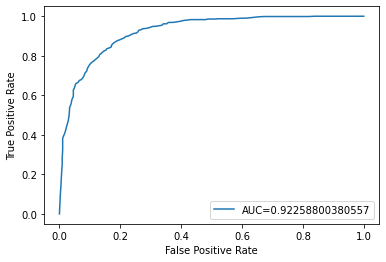

In [52]:
# Krzywa ROC
ROC(RandomForest_model, x_test_norm, y_test)

In [53]:
# Podsumowując lasy losowe skuteczniej klasyfikują dane, zarówno wskaźniki takie jak
# dokładnoś, precyzja, czułośc przyjmują znacznie korzystniejsze wartości. 
# Ponadto pole pod krzywą ROC jest większe o 0,07 w porównaniu z modelem regresji logistycznej.
